In [1]:
from src.lstm_ed import LSTM_ED
from src import pipeline

import torch
import src
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
# from sklearn.preprocessing import LabelEncoder
# from datasets import ucr_2018, utils

# train_df, test_df = ucr_2018.get_dataset("ECG200")
# X_train, y_train = utils.x_y_split(train_df, y_col=0)
# X_test, y_test = utils.x_y_split(test_df, y_col=0)

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [3]:
# params = {
#     'batch_size': 10,
#     'shuffle': True
# }

# train = torch.utils.data.TensorDataset(
#     torch.from_numpy(X_train.values).unsqueeze(-1).float().to(device),
#     torch.tensor(y_train).to(device)
# )
# train_loader = torch.utils.data.DataLoader(train, **params)

# test = torch.utils.data.TensorDataset(
#     torch.from_numpy(X_test.values).unsqueeze(-1).float().to(device),
#     torch.tensor(y_test).to(device)
# )
# test_loader = torch.utils.data.DataLoader(test, **params)

In [4]:
# epochs = 10
# model = LSTM_ED(input_size=1, seq_len=96, device=device)
# model.train(train_loader=train_loader, validation_loader=None,
#             data_storage="records", epochs=epochs, model_name="LSTM-ED",
#             logdir="logs", verbose=1)

In [5]:
window_size = 64
train_loader, test_loader, test_df = pipeline.create_sin_dataset(
    window_size=window_size,
    device=device,
    shuffle=False,
    return_val_df=True,
    model_type="LSTM"
)

Epoch 0, dataset train: Loss - 0.505886, MSE - 0.505886
Epoch 1, dataset train: Loss - 0.497169, MSE - 0.497169
Epoch 2, dataset train: Loss - 0.485119, MSE - 0.485119
Epoch 3, dataset train: Loss - 0.436420, MSE - 0.436420
Epoch 4, dataset train: Loss - 0.422847, MSE - 0.422847
Epoch 5, dataset train: Loss - 0.414886, MSE - 0.414886
Epoch 6, dataset train: Loss - 0.403754, MSE - 0.403754
Epoch 7, dataset train: Loss - 0.376685, MSE - 0.376685
Epoch 8, dataset train: Loss - 0.207400, MSE - 0.207400
Epoch 9, dataset train: Loss - 0.053893, MSE - 0.053893
Epoch 0, dataset train detector: Loss - 0.031734, MSE - 0.031734
Epoch 0, dataset evaluate detector: Loss - 0.080107, MSE - 0.080107


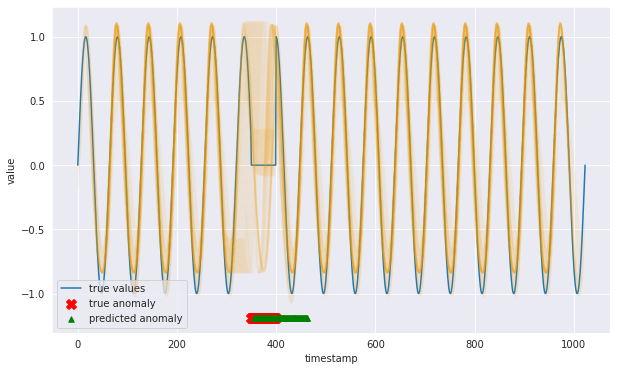

In [6]:
params = {
    "input_size": 1
}
pipeline.train_evaluate(
    train_loader=train_loader,
    test_loader=test_loader,
    test_df=test_df,
    window_size=window_size,
    AnomalyDetector=LSTM_ED,
    model_name="LSTM-ED",
    n_epochs=10,
    verbose=1,
    plot_results=True,
    device=device,
    **params
)

In [7]:
None=1

SyntaxError: cannot assign to None (<ipython-input-7-c50d50884aea>, line 1)

In [6]:
epochs = 10
model = LSTM_ED(input_size=1, seq_len=window, device=device)
model.train(train_loader=train_loader, validation_loader=None,
            data_storage="records", epochs=epochs, model_name="LSTM-ED",
            logdir="logs", verbose=1)

Epoch 0, dataset train: Loss - 0.499143, MSE - 0.499143
Epoch 1, dataset train: Loss - 0.493235, MSE - 0.493235
Epoch 2, dataset train: Loss - 0.465950, MSE - 0.465950
Epoch 3, dataset train: Loss - 0.420269, MSE - 0.420269
Epoch 4, dataset train: Loss - 0.409031, MSE - 0.409031
Epoch 5, dataset train: Loss - 0.399080, MSE - 0.399080
Epoch 6, dataset train: Loss - 0.383831, MSE - 0.383831
Epoch 7, dataset train: Loss - 0.329011, MSE - 0.329011
Epoch 8, dataset train: Loss - 0.165869, MSE - 0.165869
Epoch 9, dataset train: Loss - 0.057312, MSE - 0.057312


In [7]:
model.train_detector(train_loader)
# true_anomalies, pred_anomalies = model.evaluate_detector(test_loader)
# pipeline.plot_with_anomalies(df, np.where(true_anomalies > 0)[0], np.where(pred_anomalies > 0)[0], window=window)

Epoch 0, dataset train detector: Loss - 0.027108, MSE - 0.027108


# Brudnopis

In [8]:
# from scipy.sparse import csr_matrix

# m = csr_matrix((len(df), len(df)))
# for i, (x_batch, _, _) in enumerate(test_loader):
#     x_pred = model(x_batch).cpu().detach().numpy()
#     batch_size = x_pred.shape[0]
#     for j in range(batch_size):
#         m[[i*batch_size + j]*window, list(range(i*batch_size + j, i*batch_size + j + window))] =\
#             x_pred[j, :, 0]
# m

In [9]:
# m_arr = m.toarray()
# x_pred_mean = [m_arr[:,i].sum()/np.count_nonzero(m_arr[:,i]) for i in range(m_arr.shape[0])]
# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(df.index, df["value"], label="true")
# ax.plot(df.index, x_pred_mean, label="predicted")
# ax.legend()
# ax.set_title("Averaged output of LSTM-ED")
# plt.show();

In [10]:
# x_pred = model(test_loader.dataset[:][0]).squeeze(-1).cpu().detach().numpy()
# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(df.index, df["value"])
# for i in range(len(x_pred)):
#     ax.plot(df.index[i:i+window], x_pred[i], color="orange", alpha=0.04)
# ax.legend()
# ax.set_title("Averaged output of LSTM-ED")
# plt.show();

Epoch 0, dataset evaluate detector: Loss - 0.080229, MSE - 0.080229


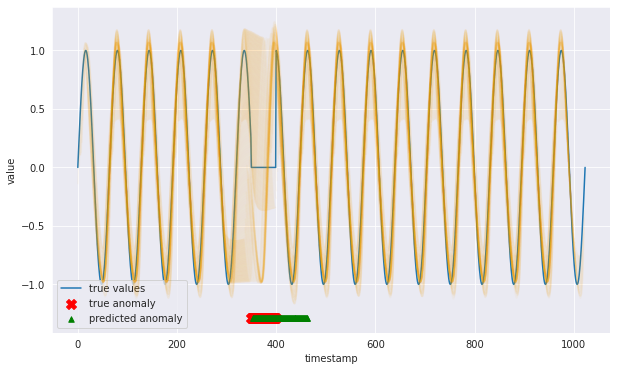

In [11]:
pipeline.show_results(
    model=model,
    validation_df=df,
    validation_loader=test_loader,
    window_size=window
)

In [12]:
#!rm -rf ./logs/LSTM-ED